## Modeling of bank failures by FDIC 



In this assignment you will be using:
- Decision Trees
- Random Forests
- Boosted Trees

All in the context of classification problem as applied to bank defaults data set.
Let's get started!

## About iPython Notebooks ##

iPython Notebooks are interactive coding environments embedded in a webpage. You will be using iPython notebooks in this class. You only need to write code between the ### START CODE HERE ### and ### END CODE HERE ### comments. After writing your code, you can run the cell by either pressing "SHIFT"+"ENTER" or by clicking on "Run Cell" (denoted by a play symbol) in the upper bar of the notebook. 

We will often specify "(≈ X lines of code)" in the comments to tell you about how much code you need to write. It is just a rough estimate, so don't feel bad if your code is longer or shorter.

In [37]:
import pandas as pd
import numpy as np
import time

import os
import functools
import math
import random
import sys, getopt

sys.path.append("..")
import grading

try:
    import matplotlib.pyplot as plt
    %matplotlib inline
except:
    pass

In [38]:
### ONLY FOR GRADING. DO NOT EDIT ###
submissions=dict()
assignment_key="HnqO7_GcEeeQcBJXIhP2bA" 
all_parts=["Pb9kd", "ZdjyW", "IfVpy","Tifr3","X8djk"]
### ONLY FOR GRADING. DO NOT EDIT ###

In [39]:
# COURSERA_TOKEN = # the key provided to the Student under his/her email on submission page
# COURSERA_EMAIL = # the email
COURSERA_TOKEN=" "
COURSERA_EMAIL=" "

In [40]:
# common cell - share this across notebooks
state_cols = ['log_TA','NI_to_TA', 'Equity_to_TA', 'NPL_to_TL', 'REO_to_TA', 
              'ALLL_to_TL', 'core_deposits_to_TA', 'brokered_deposits_to_TA', 
              'liquid_assets_to_TA', 'loss_provision_to_TL', 
              'ROA', 
              'NIM', 'assets_growth']

# Macro Economic Variables (MEVs)
all_MEVs = np.array(['term_spread',
                    'stock_mkt_growth',
                    'real_gdp_growth',
                    'unemployment_rate_change',
                    'treasury_yield_3m',
                    'bbb_spread',
                    'bbb_spread_change'])

MEV_cols = all_MEVs.tolist()

next_state_cols = ['log_TA_plus_1Q','NI_to_TA_plus_1Q', 'Equity_to_TA_plus_1Q', 'NPL_to_TL_plus_1Q', 'REO_to_TA_plus_1Q', 
                   'ALLL_to_TL_plus_1Q', 'core_deposits_to_TA_plus_1Q', 'brokered_deposits_to_TA_plus_1Q', 
                   'liquid_assets_to_TA_plus_1Q', 'loss_provision_to_TL_plus_1Q', 
                   'ROA_plus_1Q', 
                   'NIM_plus_1Q', 
                   'assets_growth_plus_1Q', 
                   'FDIC_assessment_base_plus_1Q_n']


In [41]:
df_train = pd.read_hdf('/home/jovyan/work/readonly/df_train_FDIC_defaults_1Y.h5', key='df')
df_test = pd.read_hdf('/home/jovyan/work/readonly/df_test_FDIC_defaults_1Y.h5', key='df')
df_data = pd.read_hdf('/home/jovyan/work/readonly/data_adj_FDIC_small.h5', key='df')
df_closure_learn = pd.read_hdf('/home/jovyan/work/readonly/df_FDIC_learn.h5', key='df')

df_all_defaulters_in_1Y = df_closure_learn[df_closure_learn.defaulter == 1].reset_index().groupby('IDRSSD').apply(lambda g: g.iloc[len(g)-3])
selected_dates = df_all_defaulters_in_1Y.date.unique()
defaulted_banks = df_all_defaulters_in_1Y['IDRSSD'].unique()
print('Number of unique dates on which defaulted within 1-st year %d'  % len(selected_dates))
print('Number of unique banks defaulted within 1-st year %d' % len(defaulted_banks))

# failure dates
# df_data[df_data['Failure / Assistance '].notnull()].date.value_counts()

Number of unique dates on which defaulted within 1-st year 39
Number of unique banks defaulted within 1-st year 472


In [13]:
# function for a flexible way to make the train and test sets
def make_train_and_test(df_in, perc_train=66.0, split_by_IDRSSD=True):
    
    reset_index_flag=False
    df = df_in.copy()
    if 'IDRSSD' in df.index.names:
        reset_index_flag = True
        df.reset_index(inplace=True)
    
    len_df = len(df)
    len_df_train = int(np.floor(0.01*perc_train*len_df))
    
    if split_by_IDRSSD == True:
        # split by names
        unique_IDRSSD = df.IDRSSD.unique()
        num_unique_IDRSSD = len(unique_IDRSSD)
        num_IDRSSD_train = int(np.floor(0.01*perc_train*num_unique_IDRSSD))
        
        # re-shuffle the list of IDRSSD
        np.random.shuffle(unique_IDRSSD)
        IDRSSD_train = unique_IDRSSD[0:num_IDRSSD_train]
        IDRSSD_test = unique_IDRSSD[num_IDRSSD_train:]
        
        df_train = df[np.in1d(df.IDRSSD, IDRSSD_train)].copy()
        df_test = df[np.in1d(df.IDRSSD, IDRSSD_test)].copy()
        
    elif split_by_IDRSSD == False:
        # split by rows
    
        idx = np.arange(len_df)
        np.random.shuffle(idx)
        df_train = df.ix[idx[0:len_df_train]]
        df_test = df.ix[idx[len_df_train:]]

    return df_train, df_test   

### Visualize binary classification data

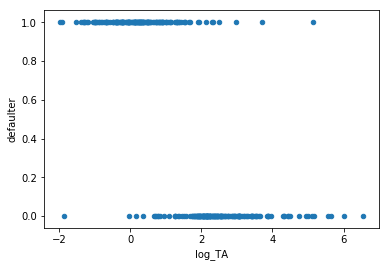

In [14]:
df_test.plot(x=state_cols[0], y='defaulter', kind='scatter')

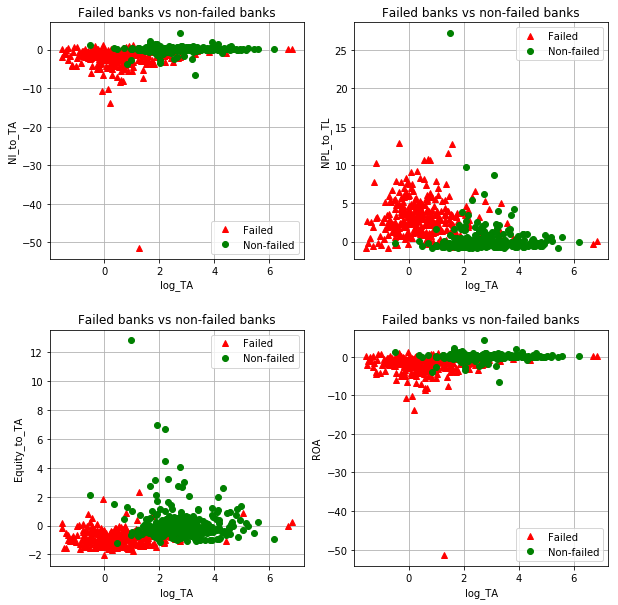

In [15]:
# Plot 4 scatter plots together

# log_TA / NI_to_TA
# log_TA / NPL_to_TL
# log_TA / Equity_to_TA
# log_TA / ROA

first_indx = [0, 0, 0, 0]
second_indx = [1, 3, 2, 10]

X_train = df_train[state_cols].values
y_train = df_train.defaulter.values # .reshape(-1,1)

num_plots = 4
if num_plots % 2 == 0:
    f, axs = plt.subplots(num_plots // 2, 2)
else:
    f, axs = plt.subplots(num_plots// 2 + 1, 2)
    
f.subplots_adjust(hspace=.3)
f.set_figheight(10.0)
f.set_figwidth(10.0)
    
for i in range(num_plots):
    if i % 2 == 0:
        first_idx = i // 2
        second_idx = 0
    else:
        first_idx = i // 2
        second_idx = 1
        
    axs[first_idx,second_idx].plot(X_train[y_train == 1.0, first_indx[i]], 
                                   X_train[y_train == 1.0, second_indx[i]], 'r^', label="Failed")
    axs[first_idx,second_idx].plot(X_train[y_train == 0.0, first_indx[i]], 
                                   X_train[y_train == 0.0, second_indx[i]], 'go', label="Non-failed") 
    
    axs[first_idx, second_idx].legend()
    axs[first_idx, second_idx].set_xlabel('%s' % state_cols[first_indx[i]])
    axs[first_idx, second_idx].set_ylabel('%s' % state_cols[second_indx[i]])
    axs[first_idx, second_idx].set_title('Failed banks vs non-failed banks')
    axs[first_idx, second_idx].grid(True) 
    
if num_plots % 2 != 0:
    f.delaxes(axs[i // 2, 1])
    
# plt.savefig('Failed_vs_nonfailed_rr_plot.png')

In [16]:
state_cols

['log_TA',
 'NI_to_TA',
 'Equity_to_TA',
 'NPL_to_TL',
 'REO_to_TA',
 'ALLL_to_TL',
 'core_deposits_to_TA',
 'brokered_deposits_to_TA',
 'liquid_assets_to_TA',
 'loss_provision_to_TL',
 'ROA',
 'NIM',
 'assets_growth']

In [17]:
# Column 'ROA' is redundant, it is the same as NI_to_TA, so remove it
state_cols = [c for c in state_cols if c != 'ROA']

print(state_cols)
print('Len state_cols = ', len(state_cols)) 

['log_TA', 'NI_to_TA', 'Equity_to_TA', 'NPL_to_TL', 'REO_to_TA', 'ALLL_to_TL', 'core_deposits_to_TA', 'brokered_deposits_to_TA', 'liquid_assets_to_TA', 'loss_provision_to_TL', 'NIM', 'assets_growth']
Len state_cols =  12


In [18]:
# make the train and test datasets
choice = 0  # selection of predictors. Add tangible equity and assessment base as predictors
predict_within_1Y = False # True

if choice == -1: # only state cols
    cols = state_cols 
elif choice == 0:  # original variables
    cols = state_cols + MEV_cols 

trX = df_train[cols].values
teX = df_test[cols].values
num_features = len(cols)    

if predict_within_1Y == True:
    trY = df_train[['default_within_1Y','no_default_within_1Y']].values
    teY = df_test[['default_within_1Y','no_default_within_1Y']].values
else:
    trY = df_train[['defaulter','non_defaulter']].values
    teY = df_test[['defaulter','non_defaulter']].values

num_classes = 2
num_components = len(cols)

In [19]:
# look at correlations
df_train[MEV_cols].corr()

,term_spread,stock_mkt_growth,real_gdp_growth,unemployment_rate_change,treasury_yield_3m,bbb_spread,bbb_spread_change
term_spread,1.000000,0.002993,-0.145941,0.299972,-0.633991,0.392349,-0.465767
stock_mkt_growth,0.002993,1.000000,-0.148941,0.461947,-0.081915,0.417379,-0.762702
real_gdp_growth,-0.145941,-0.148941,1.000000,-0.825802,0.041596,-0.820518,0.385007
unemployment_rate_change,0.299972,0.461947,-0.825802,1.000000,0.034355,0.881223,-0.657093
treasury_yield_3m,-0.633991,-0.081915,0.041596,0.034355,1.000000,-0.272072,0.290414
bbb_spread,0.392349,0.417379,-0.820518,0.881223,-0.272072,1.000000,-0.716249
bbb_spread_change,-0.465767,-0.762702,0.385007,-0.657093,0.290414,-0.716249,1.000000


In [20]:
print(teY[:, 0].sum())
print(df_test.defaulter.sum())
print('num_components: %d' % num_components)
state_cols

161.0
161.0
num_components: 19


['log_TA',
 'NI_to_TA',
 'Equity_to_TA',
 'NPL_to_TL',
 'REO_to_TA',
 'ALLL_to_TL',
 'core_deposits_to_TA',
 'brokered_deposits_to_TA',
 'liquid_assets_to_TA',
 'loss_provision_to_TL',
 'NIM',
 'assets_growth']

In [21]:
from sklearn import neighbors, linear_model
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

col_start = 0 # 19
comp_to_keep = num_components

In [22]:
# Do Logistic Regression with a smaller number of predictor, based on analysis of P-values 
# for the logistic regression with a full set of variables

# the original set of predictors
# cols_to_use = state_cols + MEV_cols  

# a smaller set is based on the analysis of P-values for the logistic regression
cols_to_use = ['log_TA', 'NI_to_TA', 'Equity_to_TA', 'NPL_to_TL',
               'core_deposits_to_TA',
               'brokered_deposits_to_TA',
               'liquid_assets_to_TA',
               'FDIC_assessment_base_n'
              ] + ['term_spread','stock_mkt_growth']
              
cols_to_use = state_cols + MEV_cols

### Make corrections for downsampling
compute the ratio 
$$r = N_{Y=0}^{\text{sub_sampled}}/N_{Y=0}^{\text{total}}$$

In [23]:
# it would be more accurate to adjust for a different average number of observations for failed and non-failed banks
# but they turn out to be almost equal, so this can be neglected:

df_data['num_records'] = df_data.groupby('IDRSSD').size()

# average number of observations for failed banks
mean_num_obs_failed_banks = df_data.loc[df_data.defaulter==1,'num_records'].mean()
mean_num_obs_nonfailed_banks = df_data.loc[df_data.defaulter==0,'num_records'].mean()

ratio_av_num_steps = float(mean_num_obs_failed_banks)/mean_num_obs_nonfailed_banks

print(mean_num_obs_failed_banks)
print(mean_num_obs_nonfailed_banks)
print(ratio_av_num_steps)

48.7881355932
47.1636542885
1.03444349954


### Receiver Operating Characteristic (ROC)
As described in scikit-learn documentation
http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html :

Receiver Operating Characteristic (ROC) - metric to evaluate classifier output quality.
ROC curves typically feature true positive rate on the Y axis, and false positive rate on the X axis. This means that the top left corner of the plot is the “ideal” point - a false positive rate of zero, and a true positive rate of one. This is not very realistic, but it does mean that a larger area under the curve (AUC) is usually better.

The “steepness” of ROC curves is also important, since it is ideal to maximize the true positive rate while minimizing the false positive rate.

## Decision Trees

###  Decision Tree Classifier Part 1

In this exercise use **DecisionTreeClassifier** from module sklearn.tree to classify banks into defaulters and non-defaulters. Use the following parameters to instantiate DecisionTreeClassifier

 - The maximum depth of the tree. Value = 5
 - The minimum number of samples required to split an internal node. Value = 50 (be sure to pass an integer)
 - Class weight: 'balanced'. The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))
 - Threshold for early stopping in tree growth. A node will split if its impurity is above the threshold, otherwise it is a leaf. Value = 0.1
 - The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. Samples have equal weight when sample_weight is not provided. Value = 0.01

In [24]:
from sklearn import neighbors, linear_model
from sklearn import metrics 

random_state = 1873111803
def plot_roc(model, parameters, y_true):
    """
    Arguments:
    model - trained model such as DecisionTreeClassifier, etc.
    parameters - array-like or sparse matrix of shape  [n_samples, n_features]. The input samples. 
    y_true - True binary labels in range {0, 1} or {-1, 1}. If labels are not binary, pos_label should be explicitly given.
    """
    if model is None:
        return 0., 0., np.array([])
    
    predicted = model.predict_proba(parameters)[:,1]
    threshold = 0.5
    predicted_binary = (predicted > threshold).astype(int)
    
    fpr, tpr, threshold = metrics.roc_curve(y_true, predicted, pos_label=1)

    roc_auc = metrics.auc(fpr, tpr) 
    ks = np.max(tpr - fpr) # Kolmogorov-Smirnov test

    print('ROC_auc = ', roc_auc)
    print('KS_test = ', ks)
    print('AUC score: %f ' % metrics.roc_auc_score(y_true, predicted)) 

    try:
        plt.title('%s ROC curve ' % model.__class__.__name__)
        plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
        plt.legend(loc='lower right')
        plt.plot([0,1], [0,1], 'r--')
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')

        # plt.savefig('ROC_curve.png')
        plt.show()
    except: pass
    return roc_auc, ks, threshold

roc_auc = 0. 
ks = 0.
single_tree = None
### START CODE HERE ### (≈ 5-8 lines of code)
# Instantiate Decision Tree Classifier and fit the model
# Reference Decision Tree Classifier model using single_tree variable
# Use cols_to_use attributes from df_train data set. Labels are in column defaulter


### END CODE HERE ###

if single_tree is not None:
    # threshold : Decreasing thresholds on the decision function used to compute fpr and tpr. thresholds[0] 
    # represents no instances being predicted and is arbitrarily set to max(y_score) + 1.
    single_tree.fit(df_train[cols_to_use].values, df_train.defaulter)
    
roc_auc, ks, threshold = plot_roc(single_tree, df_test[cols_to_use], df_test.defaulter)

In [25]:
### GRADED PART (DO NOT EDIT) ###
part_1 = np.array([roc_auc, ks]).squeeze()
try:
    part1 = " ".join(map(repr, part_1))
except TypeError:
    part1 = repr(part_1)
submissions[all_parts[0]]=part1
grading.submit(COURSERA_EMAIL, COURSERA_TOKEN, assignment_key,all_parts[:1],all_parts,submissions)
[roc_auc, ks]
### GRADED PART (DO NOT EDIT) ###

Something went wrong, please have a look at the reponse of the grader
-------------------------
{"errorCode":null,"message":"Unparseable id header: None","details":null}
-------------------------


[0.0, 0.0]

###  Decision Tree Classifier Part 2
Now using DecisionTreeClassifier and the same predictors of bank failure we will predict bank failure within the first year.

In [26]:
if single_tree is not None:
    single_tree.fit(df_train[cols_to_use].values, df_train.default_within_1Y)
roc_auc, ks, threshold = plot_roc(single_tree, df_test[cols_to_use], df_test.default_within_1Y)

In [27]:
### GRADED PART (DO NOT EDIT) ###
part_2 = np.array([roc_auc, ks]).squeeze()
try:
    part2 = " ".join(map(repr, part_2))
except TypeError:
    part2 = repr(part_2)
submissions[all_parts[1]]=part2
grading.submit(COURSERA_EMAIL, COURSERA_TOKEN, assignment_key,all_parts[:2],all_parts,submissions)
[roc_auc, ks]
### GRADED PART (DO NOT EDIT) ###

Something went wrong, please have a look at the reponse of the grader
-------------------------
{"errorCode":null,"message":"Unparseable id header: None","details":null}
-------------------------


[0.0, 0.0]

### Random Forests

### Random Forests Part 3
As defined by http://scikit-learn.org/stable/modules/ensemble.html:

In random forests (see RandomForestClassifier and RandomForestRegressor classes), each tree in the ensemble is built from a sample drawn with replacement (i.e., a bootstrap sample) from the training set. In addition, when splitting a node during the construction of the tree, the split that is chosen is no longer the best split among all features. Instead, the split that is picked is the best split among a random subset of the features. As a result of this randomness, the bias of the forest usually slightly increases (with respect to the bias of a single non-random tree) but, due to averaging, its variance also decreases, usually more than compensating for the increase in bias, hence yielding an overall better model.

Use the following parameters to instantiate **RandomForestClassifier**:

- The number of features to consider when looking for the best split. Value = 0.5
- The number of trees in the forest. Value = 1000
- The maximum depth of the tree. Value = 5

In [28]:
from sklearn.ensemble import RandomForestClassifier

clf  = None
 ### START CODE HERE ### (≈ 2 lines of code) 
# instantiate Random Forest Classifier
# reference Random Forest Classifier model using clf variable
# ... please set random_state=42 in a random forest classifier of sklearn

### END CODE HERE ###

# use all columns for this examples, including marcro economic variables
cols_to_use = state_cols[:-1] + MEV_cols  
if clf is not None:
    clf.fit(df_train[cols_to_use].values, df_train.defaulter)
roc_auc, ks, threshold = plot_roc(clf, df_test[cols_to_use], df_test.defaulter)

In [29]:
### GRADED PART (DO NOT EDIT) ###
part_3 = np.array([roc_auc, ks]).squeeze()
try:
    part3 = " ".join(map(repr, part_3))
except TypeError:
    part3 = repr(part_3)
submissions[all_parts[2]]=part3
grading.submit(COURSERA_EMAIL, COURSERA_TOKEN, assignment_key,all_parts[:3],all_parts,submissions)
[roc_auc, ks]
### GRADED PART (DO NOT EDIT) ###

Something went wrong, please have a look at the reponse of the grader
-------------------------
{"errorCode":null,"message":"Unparseable id header: None","details":null}
-------------------------


[0.0, 0.0]

### Feature importance from random forest

In [30]:
importance = []
if clf is not None:
    importance = clf.feature_importances_
    importance = pd.DataFrame(importance, index=df_train[cols_to_use].columns, 
                              columns=["Importance"])

    importance["Std"] = np.std([tree.feature_importances_
                                for tree in clf.estimators_], axis=0)

    x = range(importance.shape[0])
    y = importance.iloc[:, 0] 
    yerr = importance.iloc[:, 1] 

    plt.bar(x, y, yerr=yerr, align="center")
    plt.xlabel('features')
    plt.ylabel('Feature importance')
    plt.title('Importance of different features')
    plt.show()

In [31]:
importance

[]

### Visualize decision trees as binary tree

In [32]:
# plot the tree
from sklearn.externals.six import StringIO
from sklearn import tree
import pydot

if clf is not None:
    try:
        dot_data = StringIO()
        tree_estimator = clf.estimators_[0]
        tree.export_graphviz(single_tree.tree_, out_file=dot_data,
                            feature_names=cols_to_use,
                            proportion=True,
                            max_depth=4)

        graph = pydot.graph_from_dot_data(dot_data.getvalue())
        # help(graph[0])

        from IPython.display import Image, display

        def viewPydot(pdot):
            plt = Image(pdot.create_png())
            display(plt)

        viewPydot(graph[0])
        # do not write graph to disk, instead write it to the screen
        # dependencies on OS X: brew install graphviz
        # dependencies on Ubuntu: sudo apt-get install graphviz
        # graph[0].write_png('single_tree_graph' + '.png')
    except: pass

## Boosted tree

### Part 4
As per http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html:

GradientBoostingClassifier builds an additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions. In each stage n_classes_ regression trees are fit on the negative gradient of the binomial or multinomial deviance loss function. Binary classification is a special case where only a single regression tree is induced.

Use the following parameters to instantiate **GradientBoostingClassifier**:

- The minimum number of samples required to split an internal node. Value = 5
- The number of boosting stages to perform. Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance. Value = 500
- Learning rate. Learning rate shrinks the contribution of each tree by learning_rate. There is a trade-off between learning rate and number of boosting stages to perform. Value = 0.05
- The maximum depth of the tree. Value = 4
- The number of features to consider when looking for the best split. Value = 1.0 (be sure to use float). If float, then max features is a percentage and int(max_features * n_features) features are considered at each split.
- random state (be sure to provide and int)

In [33]:
gbt = None
roc_auc = 0.
ks = 0.
### START CODE HERE ### (≈ 7 lines of code)
# ... please set random_state=42 in a random forest classifier of sklearn

### END CODE HERE ###
if gbt is not None:
    gbt.fit(df_train[cols_to_use].values,df_train.defaulter)
    roc_auc, ks, threshold = plot_roc(gbt, df_test[cols_to_use], df_test.defaulter)

In [34]:
### GRADED PART (DO NOT EDIT) ###
part_4 = np.array([roc_auc, ks]).squeeze()
try:
    part4 = " ".join(map(repr, part_4))
except TypeError:
    part4 = repr(part_4)
submissions[all_parts[3]]=part4
grading.submit(COURSERA_EMAIL, COURSERA_TOKEN, assignment_key,all_parts[:4],all_parts,submissions)
[roc_auc, ks]
### GRADED PART (DO NOT EDIT) ###

Something went wrong, please have a look at the reponse of the grader
-------------------------
{"errorCode":null,"message":"Unparseable id header: None","details":null}
-------------------------


[0.0, 0.0]

In [35]:
roc_auc = 0.
ks = 0.
if gbt is not None:
    gbt.fit(df_train[cols_to_use].values, df_train.default_within_1Y)
    roc_auc, ks, threshold = plot_roc(gbt, df_test[cols_to_use], df_test.default_within_1Y)

In [36]:
### GRADED PART (DO NOT EDIT) ###
part_5 = np.array([roc_auc, ks]).squeeze()
try:
    part5 = " ".join(map(repr, part_5))
except TypeError:
    part5 = repr(part_5)
submissions[all_parts[4]]=part5
grading.submit(COURSERA_EMAIL, COURSERA_TOKEN, assignment_key,all_parts[:5],all_parts,submissions)
[roc_auc, ks]
### GRADED PART (DO NOT EDIT) ###

Something went wrong, please have a look at the reponse of the grader
-------------------------
{"errorCode":null,"message":"Unparseable id header: None","details":null}
-------------------------


[0.0, 0.0]